In [47]:
import json
import glob
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import fisher_exact
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns


In [48]:
# Load and normalize verdicts (handles capital letters, trailing spaces, and malformed entries)
def load_verdicts(jsonl_path):
    verdicts = {}
    hard_flags = {}
    skipped = 0
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line)
                key, value = next(iter(entry.items()))
                if isinstance(value, dict) and 'verdict' in value:
                    verdict = value['verdict'].strip().lower()
                    verdicts[key] = verdict
                    hard_flags[key] = value.get('confidence', '').strip().lower() == 'low'
                else:
                    skipped += 1
            except Exception:
                skipped += 1
    return verdicts, hard_flags, skipped

# Multiclass evaluation with label normalization and full label set
def evaluate_multiclass(y_true, y_pred, labels):
    print("Class distribution (gold):", Counter(y_true))
    print("Class distribution (pred):", Counter(y_pred))

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred, labels=labels).tolist(),
    }

# Binary evaluation (excluding 'unclear')
def evaluate_binary(y_true, y_pred):
    label_map = {'same': 1, 'different': 0}
    y_true_bin = [label_map[v] for v in y_true]
    y_pred_bin = [label_map[v] for v in y_pred]

    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0),
        "cohen_kappa": cohen_kappa_score(y_true_bin, y_pred_bin),
        "confusion_matrix": confusion_matrix(y_true_bin, y_pred_bin).tolist()
    }

# Confusion matrix heatmap

def plot_confusion_matrix_heatmap(conf_matrix, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Radar chart for metrics

def plot_radar_chart(df, metrics=["accuracy", "macro_f1", "cohen_kappa"]):
    labels = metrics
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model in df.index:
        values = df.loc[model, labels].tolist()
        values += values[:1]
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("Radar Plot of Multiclass Metrics", fontsize=14)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Analyze correlation of model errors with human-marked hard cases
def analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags):
    results = defaultdict(lambda: {'total': 0, 'errors': 0})

    for key in model_verdicts:
        if key not in gold_verdicts:
            continue
        true_label = gold_verdicts[key]
        pred_label = model_verdicts[key]
        is_hard = hard_flags.get(key, False)
        results[is_hard]['total'] += 1
        if pred_label != true_label:
            results[is_hard]['errors'] += 1

    error_summary = {}
    for hard_status, stats in results.items():
        total = stats['total']
        errors = stats['errors']
        error_rate = errors / total if total > 0 else 0
        label = 'hard' if hard_status else 'easy'
        error_summary[f"{label}_total"] = total
        error_summary[f"{label}_errors"] = errors
        error_summary[f"{label}_error_rate"] = round(error_rate * 100, 2)  # as percentage
        print(f"{label.capitalize()} cases: {errors} errors out of {total} → {error_rate:.2%}")

    return error_summary

# Main evaluation loop
def evaluate_all_models_plot(gold_path, model_pattern="results_*.jsonl"):
    gold_verdicts, hard_flags, gold_skipped = load_verdicts(gold_path)
    model_files = glob.glob(model_pattern)
    labels = ['same', 'different', 'unclear']

    metrics_summary = []

    for model_file in model_files:
        model_name = Path(model_file).stem.replace("results_", "")
        model_verdicts, _, model_skipped = load_verdicts(model_file)

        common_keys = model_verdicts.keys() & gold_verdicts.keys()

        if not common_keys:
            print(f"⚠️  Skipping model '{model_name}' — no common entries with gold standard.")
            continue

        y_true = [gold_verdicts[k] for k in common_keys]
        y_pred = [model_verdicts[k] for k in common_keys]

        try:
            multiclass = evaluate_multiclass(y_true, y_pred, labels)
            plot_confusion_matrix_heatmap(multiclass["confusion_matrix"], labels, title=f"Confusion Matrix - {model_name}")
            
            error_stats = analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

            # Run Fisher's test
            fisher = test_significance_of_error_difference(
                hard_errors=error_stats['hard_errors'],
                hard_total=error_stats['hard_total'],
                easy_errors=error_stats['easy_errors'],
                easy_total=error_stats['easy_total']
            )
            error_stats.update(fisher)

            metrics_summary.append({
                "model": model_name,
                "accuracy": multiclass["accuracy"],
                "macro_f1": multiclass["macro_f1"],
                "cohen_kappa": multiclass["cohen_kappa"],
                "skipped_entries": model_skipped,
                **error_stats
            })

            print(f"\n🔍 Hard case error analysis for model: {model_name}")
            analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

        except Exception as e:
            print(f"❌ Failed to evaluate model '{model_name}': {e}")
            continue

    if not metrics_summary:
        print("No valid model evaluations to plot.")
        return

    df = pd.DataFrame(metrics_summary)
    if 'model' not in df.columns:
        print("Missing 'model' column in metrics summary.")
        print(df)
        return

    df.set_index("model", inplace=True)

    # Bar chart
    df[["accuracy", "macro_f1", "cohen_kappa"]].plot(
        kind='bar',
        figsize=(10, 6),
        title="Multiclass Evaluation Metrics by Model"
    )
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Radar plot
    plot_radar_chart(df)

    return df

def test_significance_of_error_difference(hard_errors, hard_total, easy_errors, easy_total):
    # Construct contingency table:
    #           Error  Correct
    # Hard      a      b
    # Easy      c      d
    a = hard_errors
    b = hard_total - hard_errors
    c = easy_errors
    d = easy_total - easy_errors

    table = [[a, b], [c, d]]

    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

    print("\n📊 Fisher's Exact Test Results:")
    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-value: {p_value:.4f}")

    return {"p_value": p_value, "odds_ratio": odds_ratio}
# Example run (replace with actual file paths as needed)
# df_results = evaluate_all_models_plot("scripts/evaluation/human_results.jsonl")

Class distribution (gold): Counter({'same': 77, 'different': 16, 'unclear': 3})
Class distribution (pred): Counter({'same': 84, 'different': 12})


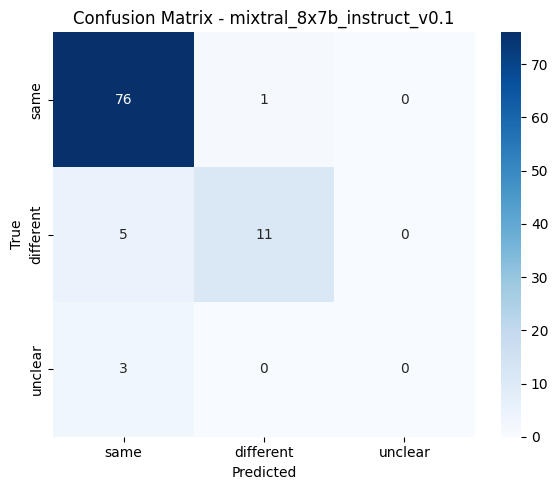

Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%

📊 Fisher's Exact Test Results:
Contingency Table: [[3, 20], [6, 67]]
Odds Ratio: 1.6750
P-value: 0.4436

🔍 Hard case error analysis for model: mixtral_8x7b_instruct_v0.1
Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 74, 'different': 26})


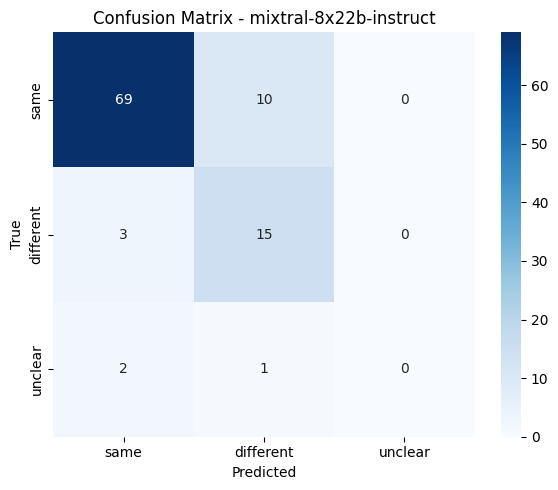

Easy cases: 8 errors out of 76 → 10.53%
Hard cases: 8 errors out of 24 → 33.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[8, 16], [8, 68]]
Odds Ratio: 4.2500
P-value: 0.0208

🔍 Hard case error analysis for model: mixtral-8x22b-instruct
Easy cases: 8 errors out of 76 → 10.53%
Hard cases: 8 errors out of 24 → 33.33%
Class distribution (gold): Counter({'same': 51, 'different': 5, 'unclear': 2})
Class distribution (pred): Counter({'same': 42, '<same | different | unclear>': 9, '': 5, 'same | different | unclear': 1, 'unclear': 1})


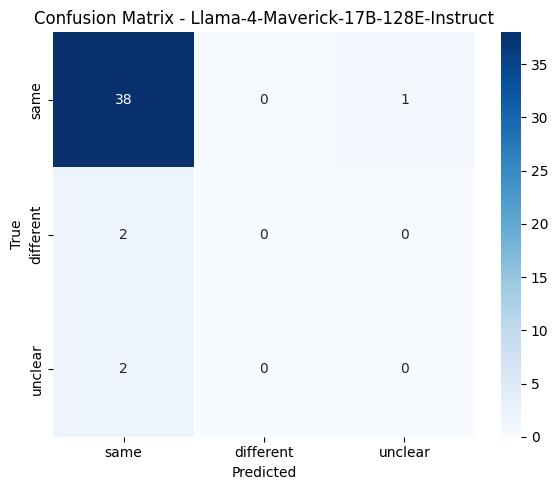

Easy cases: 17 errors out of 42 → 40.48%
Hard cases: 3 errors out of 16 → 18.75%

📊 Fisher's Exact Test Results:
Contingency Table: [[3, 13], [17, 25]]
Odds Ratio: 0.3394
P-value: 0.2154

🔍 Hard case error analysis for model: Llama-4-Maverick-17B-128E-Instruct
Easy cases: 17 errors out of 42 → 40.48%
Hard cases: 3 errors out of 16 → 18.75%
Class distribution (gold): Counter({'same': 78, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 86, 'different': 13})


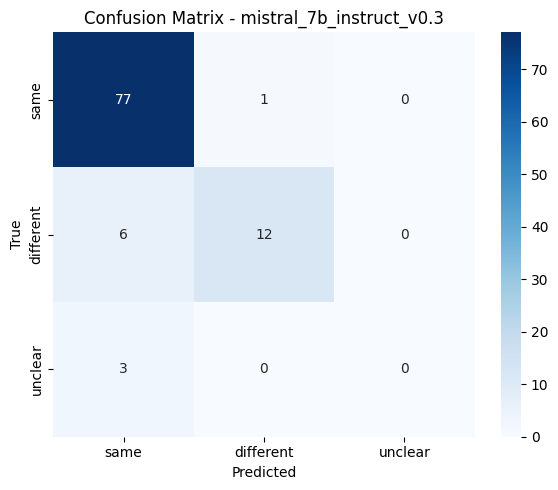

Easy cases: 8 errors out of 75 → 10.67%
Hard cases: 2 errors out of 24 → 8.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[2, 22], [8, 67]]
Odds Ratio: 0.7614
P-value: 1.0000

🔍 Hard case error analysis for model: mistral_7b_instruct_v0.3
Easy cases: 8 errors out of 75 → 10.67%
Hard cases: 2 errors out of 24 → 8.33%
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 80, 'different': 19, 'unclear': 1})


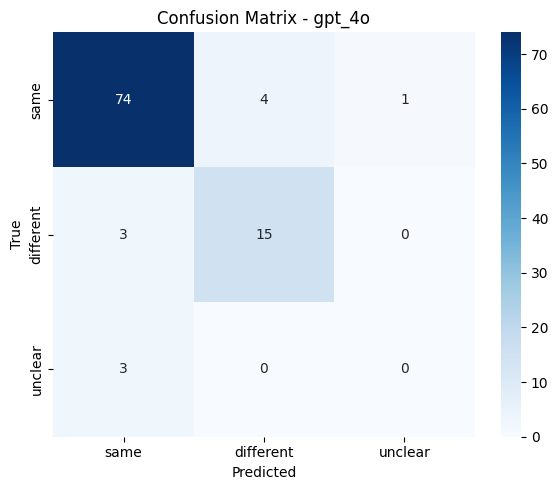

Easy cases: 9 errors out of 76 → 11.84%
Hard cases: 2 errors out of 24 → 8.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[2, 22], [9, 67]]
Odds Ratio: 0.6768
P-value: 1.0000

🔍 Hard case error analysis for model: gpt_4o
Easy cases: 9 errors out of 76 → 11.84%
Hard cases: 2 errors out of 24 → 8.33%
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 86, 'different': 14})


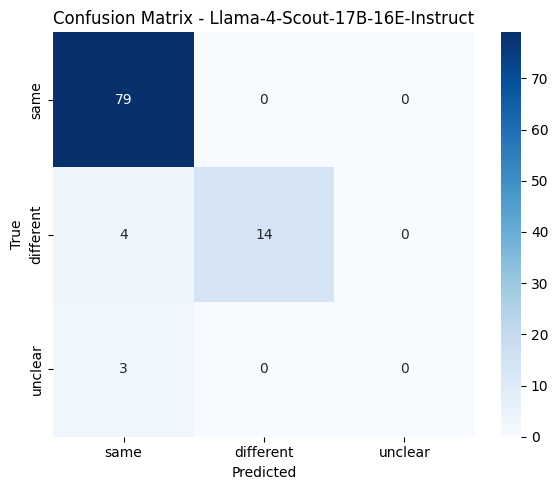

Easy cases: 5 errors out of 76 → 6.58%
Hard cases: 2 errors out of 24 → 8.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[2, 22], [5, 71]]
Odds Ratio: 1.2909
P-value: 0.6722

🔍 Hard case error analysis for model: Llama-4-Scout-17B-16E-Instruct
Easy cases: 5 errors out of 76 → 6.58%
Hard cases: 2 errors out of 24 → 8.33%
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 60, 'different': 40})


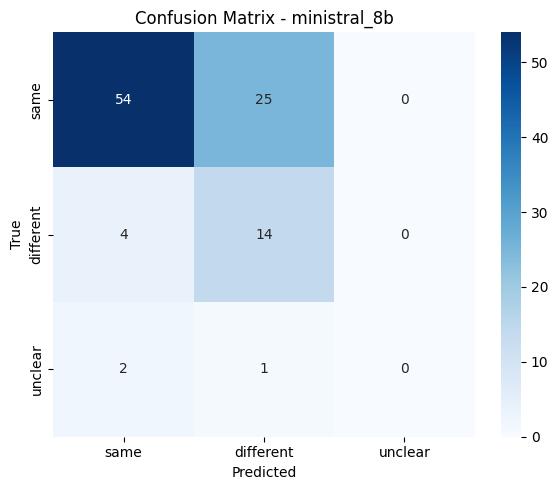

Easy cases: 19 errors out of 76 → 25.00%
Hard cases: 13 errors out of 24 → 54.17%

📊 Fisher's Exact Test Results:
Contingency Table: [[13, 11], [19, 57]]
Odds Ratio: 3.5455
P-value: 0.0116

🔍 Hard case error analysis for model: ministral_8b
Easy cases: 19 errors out of 76 → 25.00%
Hard cases: 13 errors out of 24 → 54.17%
Class distribution (gold): Counter({'same': 73, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 83, 'different': 11})


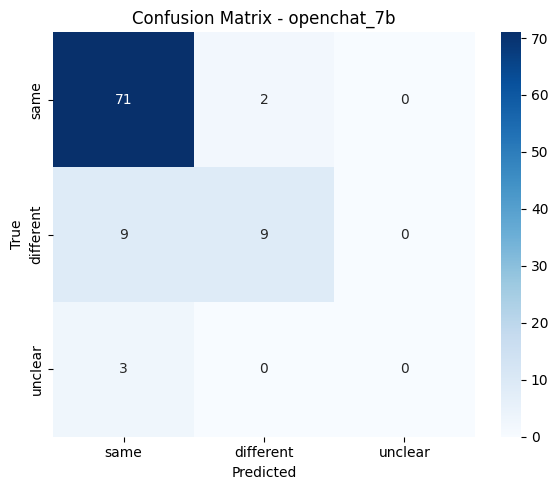

Easy cases: 11 errors out of 72 → 15.28%
Hard cases: 3 errors out of 22 → 13.64%

📊 Fisher's Exact Test Results:
Contingency Table: [[3, 19], [11, 61]]
Odds Ratio: 0.8756
P-value: 1.0000

🔍 Hard case error analysis for model: openchat_7b
Easy cases: 11 errors out of 72 → 15.28%
Hard cases: 3 errors out of 22 → 13.64%
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 70, 'different': 30})


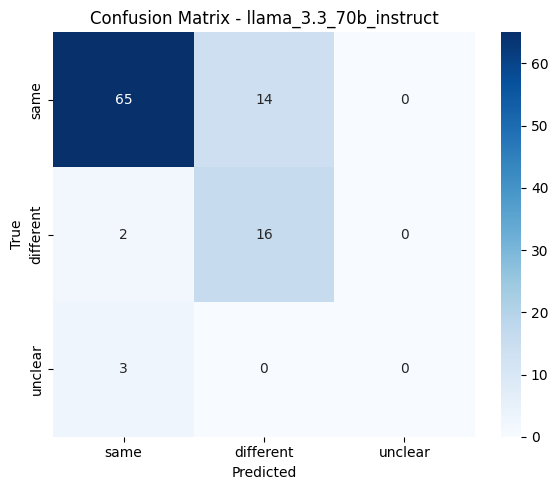

Easy cases: 11 errors out of 76 → 14.47%
Hard cases: 8 errors out of 24 → 33.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[8, 16], [11, 65]]
Odds Ratio: 2.9545
P-value: 0.0694

🔍 Hard case error analysis for model: llama_3.3_70b_instruct
Easy cases: 11 errors out of 76 → 14.47%
Hard cases: 8 errors out of 24 → 33.33%


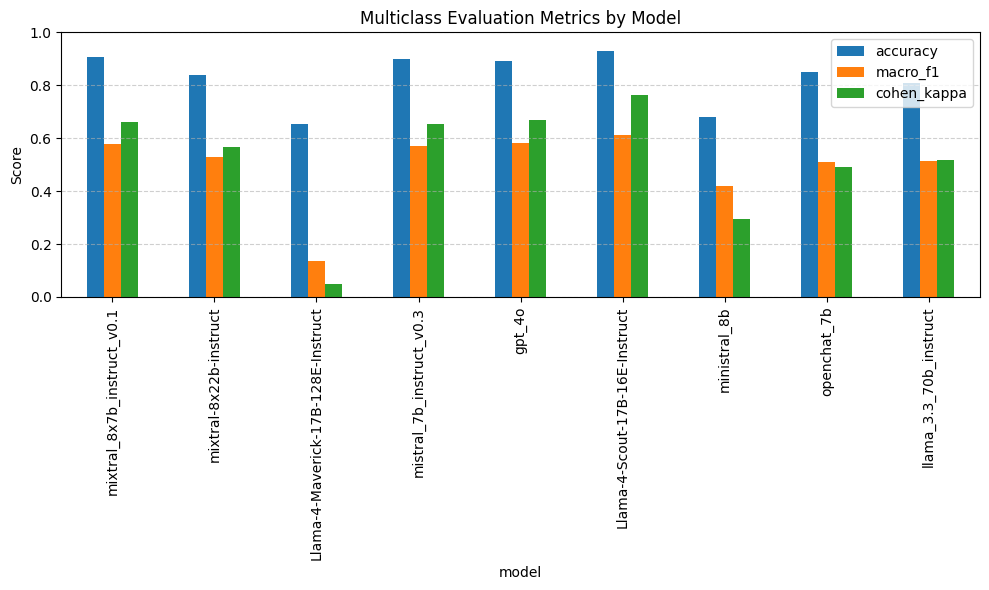

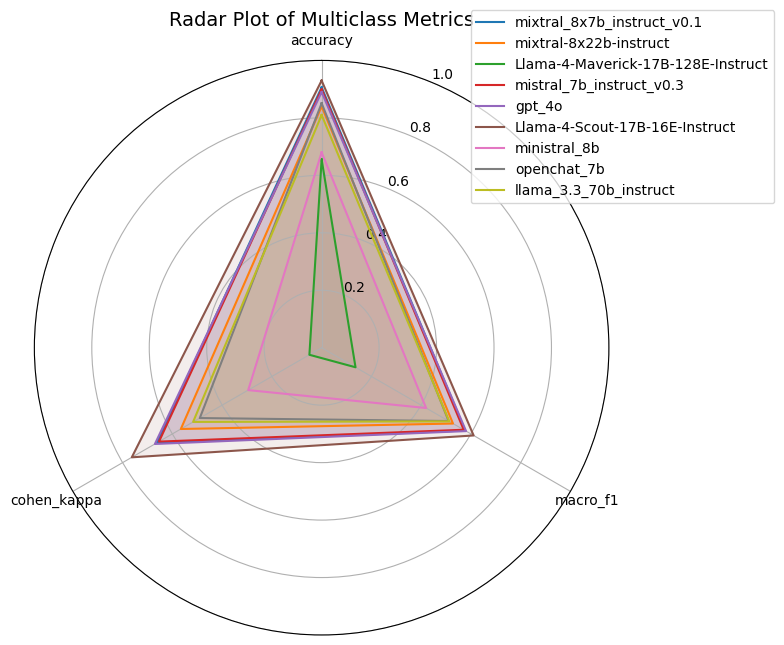

In [49]:
df_results = evaluate_all_models_plot("human_results.jsonl")

In [50]:
df_results

,accuracy,macro_f1,cohen_kappa,skipped_entries,easy_total,easy_errors,easy_error_rate,hard_total,hard_errors,hard_error_rate,p_value,odds_ratio
model,,,,,,,,,,,,
mixtral_8x7b_instruct_v0.1,0.906250,0.576605,0.661972,4,73,6,8.22,23,3,13.04,0.443602,1.675000
mixtral-8x22b-instruct,0.840000,0.527926,0.565925,0,76,8,10.53,24,8,33.33,0.020831,4.250000
Llama-4-Maverick-17B-128E-Instruct,0.655172,0.136201,0.049180,42,42,17,40.48,16,3,18.75,0.215436,0.339367
mistral_7b_instruct_v0.3,0.898990,0.571073,0.653725,1,75,8,10.67,24,2,8.33,1.000000,0.761364
gpt_4o,0.890000,0.580543,0.670165,0,76,9,11.84,24,2,8.33,1.000000,0.676768
Llama-4-Scout-17B-16E-Instruct,0.930000,0.610859,0.763033,0,76,5,6.58,24,2,8.33,0.672226,1.290909
ministral_8b,0.680000,0.419912,0.295154,0,76,19,25.00,24,13,54.17,0.011640,3.545455
openchat_7b,0.851064,0.510315,0.489725,6,72,11,15.28,22,3,13.64,1.000000,0.875598
llama_3.3_70b_instruct,0.810000,0.513050,0.516539,0,76,11,14.47,24,8,33.33,0.069385,2.954545


In [51]:
from collections import defaultdict, Counter
from scipy.stats import fisher_exact
import pandas as pd

def compute_model_agreement(model_paths, gold_path):
    # Load gold verdicts and difficulty labels
    gold_verdicts, hard_flags, _ = load_verdicts(gold_path)

    # Load all model predictions
    model_predictions = {}
    all_models = []

    for path in model_paths:
        model_name = Path(path).stem.replace("results_", "")
        preds, _, _ = load_verdicts(path)
        model_predictions[model_name] = preds
        all_models.append(model_name)

    # Build agreement table per entry
    agreement_data = []
    for key in gold_verdicts:
        if key not in hard_flags:
            continue  # skip untagged gold entries

        votes = []
        for model in all_models:
            verdict = model_predictions.get(model, {}).get(key)
            if verdict:
                votes.append(verdict)

        if not votes:
            continue  # no votes at all

        vote_counts = Counter(votes)
        majority_label, majority_count = vote_counts.most_common(1)[0]
        is_correct = majority_label == gold_verdicts[key]
        is_hard = hard_flags[key]
        total_votes = len(votes)
        disagreement = total_votes - majority_count

        agreement_data.append({
            "entry": key,
            "total_votes": total_votes,
            "majority_label": majority_label,
            "majority_count": majority_count,
            "disagreement": disagreement,
            "is_correct": is_correct,
            "is_hard": is_hard
        })

    return pd.DataFrame(agreement_data)

def analyze_agreement_effect(df):
    print("\n🔍 Agreement-level error rates:")
    df["agreement_level"] = df["majority_count"] / df["total_votes"]
    for level in sorted(df["agreement_level"].unique(), reverse=True):
        subset = df[df["agreement_level"] == level]
        if len(subset) < 3:
            continue  # skip small bins
        err_rate = 1 - subset["is_correct"].mean()
        print(f"Agreement {level:.2f} ({len(subset)} entries): Error rate = {err_rate:.2%}")

    print("\n📊 Fisher test: Errors more likely in disagreement?")
    agree = df[df["disagreement"] == 0]
    disagree = df[df["disagreement"] > 0]

    a = (agree["is_correct"] == False).sum()
    b = (agree["is_correct"] == True).sum()
    c = (disagree["is_correct"] == False).sum()
    d = (disagree["is_correct"] == True).sum()

    table = [[a, b], [c, d]]
    odds_ratio, p_value = fisher_exact(table)

    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"P-Value: {p_value:.4f}")

In [59]:
gold_path = "human_results.jsonl"
promising_models = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
    
]
model_paths = [f"{name}" for name in promising_models]
df_agree = compute_model_agreement(model_paths, gold_path)
analyze_agreement_effect(df_agree)



🔍 Agreement-level error rates:
Agreement 1.00 (94 entries): Error rate = 4.26%
Agreement 0.50 (3 entries): Error rate = 100.00%

📊 Fisher test: Errors more likely in disagreement?
Contingency Table: [[np.int64(4), np.int64(90)], [np.int64(3), np.int64(0)]]
Odds Ratio: 0.00
P-Value: 0.0002


In [60]:
def analyze_proxy_errors_vs_human_difficulty(df_agreement):
    # Focus only on errors
    errors = df_agreement[df_agreement["is_correct"] == False]

    # Count how many of those are hard for humans
    hard_errors = errors[errors["is_hard"] == True]
    easy_errors = errors[errors["is_hard"] == False]

    print(f"\n🔍 Agreement-based proxy made {len(errors)} total errors:")
    print(f"  → {len(hard_errors)} were marked as hard by humans ({len(hard_errors)/len(errors)*100:.1f}%)")
    print(f"  → {len(easy_errors)} were marked as easy by humans ({len(easy_errors)/len(errors)*100:.1f}%)")

    # Optional: return the actual rows for review
    return errors


In [62]:
analyze_proxy_errors_vs_human_difficulty(df_agree)


🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)


,entry,total_votes,majority_label,majority_count,disagreement,is_correct,is_hard,agreement_level
18,escher/lib,2,same,1,1,False,False,0.5
41,xxmotif/cmd,2,different,1,1,False,True,0.5
62,gffread/cmd,1,same,1,0,False,False,1.0
83,minimap/cmd,2,same,1,1,False,False,0.5
85,bioconductor-mygene/lib,2,same,2,0,False,False,1.0
90,gffcompare/cmd,2,same,2,0,False,True,1.0
94,rcorrector/cmd,2,same,2,0,False,True,1.0
